In [17]:
import os
import time
from sklearn.svm import SVC
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import scipy
from math import log
from numpy.fft import fft, fftfreq, ifft
from scipy.fftpack import fft
from scipy.fftpack import dct
from scipy import fftpack
from scipy import signal
import csv
from scipy.signal import filtfilt
from scipy.signal import lfilter
from scipy import stats
from scipy.signal import butter, lfilter, lfilter_zi, normalize

In [18]:
Channel = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 
           'F4', 'F8', 'AF4']
StimuliFeatures = []
BaseLineFeatures = []

In [19]:
def bandPassFilter(y, low, high):
    lowcut = low
    highcut = high
    nSamples = len(y)
    signal = y
    order = 2
    fs = nSamples
    nyq = 0.5 * fs
    l = lowcut / nyq
    h = highcut / nyq
    b, a = scipy.signal.butter(order, [l, h], btype='bandpass')
    yf = scipy.signal.filtfilt(b, a, signal, axis=0)
    return yf

In [20]:
def FFTgraph(theta_signal, alpha_signal, beta_signal, ch, check):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    plt.title("FFT " + ch + " " + check)
    n = len(theta_signal)
    x = np.linspace(0, n * (1 / 128), n)

    ax1.plot(x, theta_signal, label="Theta")
    len1 = len(alpha_signal)
    n = len1

    ax1.plot(x, alpha_signal, label="Alpha")
    n = len(beta_signal)

    ax1.plot(x, beta_signal, label="beta")
    ax1.legend()

    # Doing FFT and Ploting
    T = 1.0 / 256.0
    sample_rate = 256
    N = 1 * sample_rate

    frequency = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)

    freq_data = fft(theta_signal)
    yr = 2 / N * np.abs(freq_data[0:N // 2])
    ax2.plot(frequency, yr, label='Theta [4-8]')

    freq_data = fft(alpha_signal)
    yr = 2 / N * np.abs(freq_data[0:N // 2])
    ax2.plot(frequency, yr, label='alpha [8-13]')

    freq_data = fft(beta_signal)
    yr = 2 / N * np.abs(freq_data[0:N // 2])
    ax2.plot(frequency, yr, label='Beta [13-20]')

    ax2.legend()
    plt.show()

In [21]:
def StoreFeatures(features, id):
    if id == 'Stimuli':
        for i in range(len(features)):
            StimuliFeatures.append(features[i])
    if id == 'Baseline':
        for i in range(len(features)):
            BaseLineFeatures.append(features[i])
    pass

In [22]:
def PSD_Welch(theta_signal, alpha_signal, beta_signal):
    th_frequency, th_power = signal.welch(theta_signal, fs=len(theta_signal), nperseg=256, noverlap=128)
    al_frequency, al_power = signal.welch(alpha_signal, fs=len(alpha_signal), nperseg=256, noverlap=128)
    th_frequency, bt_power = signal.welch(beta_signal, fs=len(beta_signal), nperseg=256, noverlap=128)

    return th_power, al_power, bt_power


In [23]:
def hjorth(a):

    first_deriv = np.diff(a)
    second_deriv = np.diff(a,2)

    var_zero = np.mean(a ** 2)
    var_d1 = np.mean(first_deriv ** 2)
    var_d2 = np.mean(second_deriv ** 2)

    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility

    return activity, complexity, mobility

In [24]:
def workOnColumn(f, id):
    for i in range(len(Channel)):
        y = np.array(f[Channel[i]])  # Accessing each Channel.
        #y = preprocessing.minmax_scale(y)  # Scaling 
        #N = 0
        cutTime = 0
        # Working with each Electrode
        if id == 'Stimuli':
            cutTime = len(y) - 7680  # For Last 60 Seconds
            #N = 7680
        if id == 'Baseline':
            cutTime = len(y) - 512  # For Last 4 Seconds
            #N = 512

        Filtered_Y = bandPassFilter(y[cutTime:], 4, 30)

        theta_signal = bandPassFilter(Filtered_Y, 4, 8)
        alpha_signal = bandPassFilter(Filtered_Y, 8, 13)
        beta_signal = bandPassFilter(Filtered_Y, 13, 20)

        #Ploting - Limited Ploting , As there will be Huge Number of plots if we plot each and every signal
        #if i<1:
          #if id == 'Baseline' or id == 'Stimuli':
           # FFTgraph(theta_signal, alpha_signal, beta_signal, Channel[i], id)

        
        # FFT Features

        theta_FFT = fft(theta_signal) # Calculating FFT of Theta Band
        Ceff1 = 2 / 128 * np.abs(theta_FFT[0:128]) # Values from (0-128)Hz Frequency.

        alpha_FFT = fft(alpha_signal)# Calculating FFT of Alpha Band
        Ceff2 = 2 / 128 * np.abs(alpha_FFT[0:128]) # Values from (0-128)Hz Frequency.

        beta_FFT = fft(beta_signal)# Calculating FFT of Beta Band
        Ceff3 = 2 / 128 * np.abs(beta_FFT[0:128]) # Values from (0-128)Hz Frequency.

        FFT1 = np.max(Ceff1)
        FFT2 = np.mean(Ceff1)

        FFT3 = np.max(Ceff2)
        FFT4 = np.mean(Ceff2)

        FFT5 = np.max(Ceff3)
        FFT6 = np.mean(Ceff2)


        #DCT Features
        theta_DCT = dct(theta_signal)# Calculating FFT of Theta Band
        Ceff4= 2 / 128 * np.abs(theta_DCT[0:128]) # Values from (0-128)Hz Frequency.

        alpha_DCT = dct(alpha_signal)# Calculating FFT of Alpha Band
        Ceff5 = 2 / 128 * np.abs(alpha_DCT[0:128]) # Values from (0-128)Hz Frequency.

        beta_DCT = dct(beta_signal)# Calculating FFT of Beta Band
        Ceff6 = 2 / 128 * np.abs(beta_DCT[0:128]) # Values from (0-128)Hz Frequency.

        DCT1 = np.max(Ceff4)
        DCT2 = np.mean(Ceff4) 

        DCT3 = np.max(Ceff5)
        DCT4 = np.mean(Ceff5)

        DCT5 = np.max(Ceff6)
        DCT6 = np.mean(Ceff6)
        
        # Hjorth Parameters
  
        activity1, complexity1, mobility1 = hjorth(theta_signal)
        activity2, complexity2, mobility2 = hjorth(alpha_signal)
        activity3, complexity3, mobility3 = hjorth(beta_signal)

        # Finding PSD
        power_theta, power_alpha, power_beta = PSD_Welch(theta_signal, alpha_signal, beta_signal)

        power_theta = np.max(power_theta)
        power_alpha = np.max(power_alpha)
        power_beta = np.max(power_beta)

        #Statistical Features - (Mean, Mediun, Maximum, Var, Skewness)
        theta_mean = np.mean(theta_signal)
        theta_median = np.median(theta_signal)
        theta_max = np.max(theta_signal)
        theta_var = np.var(theta_signal)
        theta_skewness = pd.Series(theta_signal).skew()

        alpha_mean = np.mean(alpha_signal)
        alpha_median = np.median(alpha_signal)
        alpha_max = np.max(alpha_signal)
        alpha_var = np.var(alpha_signal)
        alpha_skewness = pd.Series(alpha_signal).skew()

        beta_mean = np.mean(beta_signal)
        beta_median = np.median(beta_signal)
        beta_max = np.max(beta_signal)
        beta_var = np.var(beta_signal)
        beta_skewness = pd.Series(beta_signal).skew()

        # PoinCare - SD1, SD2
        theta_data = theta_signal
        theta_diff = np.diff(theta_data)
        theta_SDSD = np.std(theta_diff)
        theta_SDNN = np.std(theta_data)
        theta_SD1 = np.sqrt(0.5 * np.power(theta_SDSD, 2))
        theta_SD2 = np.sqrt(2 * np.power(theta_SDNN, 2) - np.power(theta_SD1, 2))

        alpha_data = alpha_signal
        alpha_diff = np.diff(alpha_data)
        alpha_SDSD = np.std(alpha_diff)
        alpha_SDNN = np.std(alpha_data)
        alpha_SD1 = np.sqrt(0.5 * np.power(alpha_SDSD, 2))
        alpha_SD2 = np.sqrt(2 * np.power(alpha_SDNN, 2) - np.power(alpha_SD1, 2))

        beta_data = beta_signal
        beta_diff = np.diff(beta_data)
        beta_SDSD = np.std(beta_diff)
        beta_SDNN = np.std(beta_data)
        beta_SD1 = np.sqrt(0.5 * np.power(beta_SDSD, 2))
        beta_SD2 = np.sqrt(2 * np.power(beta_SDNN, 2) - np.power(beta_SD1, 2))
 
        AllFeatures = [theta_mean, theta_median, theta_max, theta_var, theta_skewness,
                       alpha_mean, alpha_median, alpha_max, alpha_var, alpha_skewness,
                       beta_mean, beta_median, beta_max, beta_var, beta_skewness,
                       theta_SD1, theta_SD2, alpha_SD1, alpha_SD2, beta_SD1, beta_SD2,
                       activity1, complexity1, mobility1, activity2, complexity2, mobility2, activity3, complexity3,mobility3,
                       FFT1, FFT2, FFT3, FFT4, FFT5, FFT6, DCT1, DCT2, DCT3, DCT4, DCT5, DCT6,
                       power_theta, power_alpha,power_beta] 

        StoreFeatures(AllFeatures, id)


In [25]:
total_features = 630  # 14 Channel Each having 45 features
total_Person = 23 
total_Stimuli = 18

FinalFeature = dict()
for i in range(total_features):
    FinalFeature[("Feature" + str(i + 1))] = []

# Dataset Stored in Drive 

for PersonCount in range(total_Person):
    for index in range(total_Stimuli):
        # For Stimuli
        csvStimuli = pd.read_csv('Dataset/EEG_With_Channel/person_' 
                                 + str(PersonCount + 1) + '_EEG_Stimuli_' + str(index + 1) + '.csv')
        Stimuli = pd.DataFrame(csvStimuli)
        workOnColumn(Stimuli, 'Stimuli')
        # For Baseline
        csvBaseLine = pd.read_csv('Dataset/EEG_With_Channel/person_' 
                                  + str(PersonCount + 1) + '_EEG_baseline_' + str(index + 1) + '.csv')
        Baseline = pd.DataFrame(csvBaseLine)
        workOnColumn(Baseline, 'Baseline')
        Features = np.array(StimuliFeatures) / np.array(BaseLineFeatures)

        for i in range(len(Features)):
            m = Features[i]
            if i < total_features:
                FinalFeature["Feature" + str(i + 1)].append(m)

        StimuliFeatures = []
        BaseLineFeatures = []

In [30]:
#Class Distribution of Self assesment ratings for Arousal, Valence and Dominance
ratings = pd.read_csv('Dataset/Results/AllRatings.csv')
AllRatings = pd.DataFrame(ratings)

Arousal = []
Valence = []
Dominance = []

values = AllRatings['Arousal']
for i in range(len(values)):
    if values[i] < 2:
        Arousal.extend([0]) # uninterested/bored
    else:
        Arousal.extend([1]) # excited/alert
    
values = AllRatings['Valence']
for i in range(len(values)):
    if values[i] <= 4:
        Valence.extend([0]) # unpleasant/stressed
    else:
        Valence.extend([1]) # happy/elated
        
values = AllRatings['Dominance']
for i in range(len(values)):
    if values[i]> 4:
        Dominance.extend([0]) # helpless/Without Control
    else:
        Dominance.extend([1]) # Empowered

FinalFeature['Arousal'] = Arousal
FinalFeature['Valence'] = Valence
FinalFeature['Dominance'] = Dominance




In [31]:
dx = pd.DataFrame(FinalFeature)
dx

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature624,Feature625,Feature626,Feature627,Feature628,Feature629,Feature630,Arousal,Valence,Dominance
0,0.399810,-1.183564,0.800691,0.328107,-4.978387,0.229131,0.177772,0.888415,0.739250,-0.113159,...,9.302497,11.702069,4.409205,4.709369,0.000718,0.009107,0.004324,1,0,1
1,-0.184464,-0.979555,0.102095,0.028185,-0.202161,-0.245509,0.023804,0.243781,0.124302,-0.174262,...,3.686000,4.993588,2.953509,7.196561,0.001554,0.001088,0.003254,1,0,1
2,-10.379531,0.374144,0.682109,0.575803,-4.842310,0.017298,-6.372481,1.014596,1.212745,0.411182,...,12.535871,27.688304,15.394599,27.796536,0.001183,0.019929,0.074396,1,1,1
3,0.166460,1.676887,0.146557,0.043448,0.343049,0.185492,-0.212113,0.212338,0.067883,0.197870,...,15.346914,16.837630,6.951336,7.483065,0.013361,0.019150,0.007573,1,0,1
4,0.935604,4.578757,0.913949,0.530971,4.916748,1.003016,-0.001346,0.484388,0.253078,34.804499,...,9.071553,4.495763,2.917442,4.613709,0.000162,0.002568,0.001622,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,5.545656,3.336176,2.061960,4.137637,0.466561,-1.281754,-1.976415,0.929064,1.169510,-1.670856,...,36.379542,26.575598,30.877662,24.696717,0.008660,0.074864,0.147115,1,0,1
410,-1.241642,0.112553,0.689308,0.517814,-5.058218,1.180783,1.778832,2.183805,2.919873,1.604151,...,34.707732,26.108357,23.587527,26.301476,0.008700,0.048718,0.129264,1,0,1
411,-2.638845,-2.514038,1.287163,2.850588,-0.966474,-5.171990,-0.366512,2.988450,3.993974,-1.384841,...,18.835075,25.187607,28.484518,16.023205,0.001278,0.031159,0.101728,1,0,1
412,1.400873,-0.140569,1.055900,1.448882,1.341684,-0.178660,-0.178991,1.312953,1.797478,-0.039673,...,10.486322,13.178698,21.319507,18.289449,0.002889,0.007699,0.072044,1,0,1


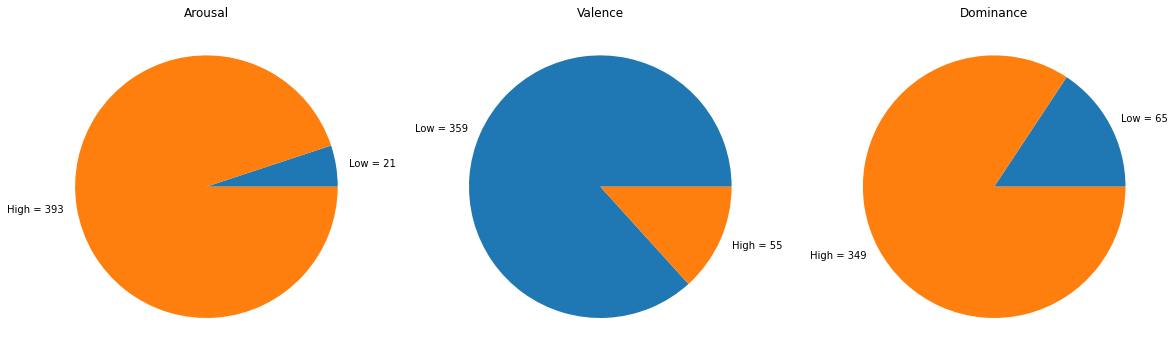

In [32]:
arousal = dx['Arousal']
valence = dx['Valence']
dominance = dx['Dominance']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
Arousalcountz = 0
Arousalcountone = 0
for i in arousal:
    if i == 0:
        Arousalcountz = Arousalcountz+1
    else:
        Arousalcountone = Arousalcountone+1


# Creating plot 
ax1.pie([Arousalcountz,Arousalcountone], labels = ['Low = '+str(Arousalcountz),'High = '+str(Arousalcountone)]) 
ax1.set_title('Arousal')

# show plot 

Valencecountz = 0
Valencecountone = 0
for i in valence:
    if i == 0:
        Valencecountz = Valencecountz+1
    else:
        Valencecountone = Valencecountone+1

# Creating plot 

ax2.pie([Valencecountz,Valencecountone], labels = ['Low = '+str(Valencecountz),'High = '+str(Valencecountone)]) 
ax2.set_title('Valence')

Dominancecountz = 0
Dominancecountone = 0
for i in dominance:
    if i == 0:
        Dominancecountz = Dominancecountz+1
    else:
        Dominancecountone = Dominancecountone+1
# Creating plot 

ax3.pie([Dominancecountz,Dominancecountone], labels = ['Low = '+str(Dominancecountz),'High = '+str(Dominancecountone)]) 
ax3.set_title('Dominance')

plt.show() 

Results Storing

In [33]:
XGBresult = []
SVMresult = []

**SVM Classifier**

In [34]:
#Support Vector Machine
model = svm.SVC(kernel='rbf', random_state = 0)  
data = dx

for Class_name in ['Arousal','Valence','Dominance']:
    y = data[Class_name]
    X = data.drop(['Arousal','Valence','Dominance'], axis=1)
    X = preprocessing.minmax_scale(X)

    # (Chi Square) It does not Increase the accuracy , rather decreases
    #X = SelectKBest(chi2, k=10).fit_transform(X, y)
    #X = pd.DataFrame(X)
    
    #Cross Validation Test Score
    cv_score = cross_val_score(model,X,y,cv = 10, scoring='accuracy')


    
    SVMresult.append(cv_score.min()*100)
    SVMresult.append(cv_score.mean()*100)
    SVMresult.append(cv_score.max()*100)

    print("SVM "+" CV Test Score of "+Class_name+':',  "%.3f" % (cv_score.min()*100), "(Minimum)")
    print("SVM "+" CV Test Score of "+Class_name+':',  "%.3f" % (cv_score.mean()*100), "(Mean)")
    print("SVM "+" CV Test Score of "+Class_name+':',  "%.3f" % (cv_score.max()*100), "(Maximum)")

    from sklearn.metrics import confusion_matrix
    #print(classification_report(y_test, y_predicted))

    print('------------------------------------------------')

SVM  CV Test Score of Arousal: 92.857 (Minimum)
SVM  CV Test Score of Arousal: 94.930 (Mean)
SVM  CV Test Score of Arousal: 95.238 (Maximum)
------------------------------------------------
SVM  CV Test Score of Valence: 85.366 (Minimum)
SVM  CV Test Score of Valence: 86.725 (Mean)
SVM  CV Test Score of Valence: 87.805 (Maximum)
------------------------------------------------
SVM  CV Test Score of Dominance: 82.927 (Minimum)
SVM  CV Test Score of Dominance: 84.309 (Mean)
SVM  CV Test Score of Dominance: 85.366 (Maximum)
------------------------------------------------


**Extreme Gradient Boosting**

In [ ]:
#Extreme Gradiant Boosing Model
from sklearn.feature_selection import SelectKBest, chi2
model = XGBClassifier(max_depth=3,
                      objective='binary:logistic',
                      n_estimators= 300,
                      learning_rate = 0.05,
                      early_stopping_rounds= 10,
                      random_state=0)
data = dx

for Class_name in ['Arousal','Valence','Dominance']:
    y = data[Class_name]
    X = data.drop(['Arousal','Valence','Dominance'], axis=1)
    X = preprocessing.minmax_scale(X)
    
    X = RFECV(estimator=model, step=1, cv=10, scoring='accuracy').fit_transform(X, y)
    X = pd.DataFrame(X) 


    #Cross Validation Test Score
    cv_score = cross_val_score(model,X,y,cv = 10, scoring='accuracy')

    XGBresult.append(cv_score.min()*100)
    XGBresult.append(cv_score.mean()*100)
    XGBresult.append(cv_score.max()*100)

    print("XGB "+" CV Test Score of "+Class_name+':',  "%.3f" % (cv_score.min()*100), "(Minimum)")
    print("XGB "+" CV Test Score of "+Class_name+':',  "%.3f" % (cv_score.mean()*100), "(Mean)" )
    print("XGB "+" CV Test Score of "+Class_name+':',  "%.3f" % (cv_score.max()*100), "(Maximum)")

    print('------------------------------------------------')

XGB  CV Test Score of Arousal: 92.857 (Minimum)
XGB  CV Test Score of Arousal: 95.174 (Mean)
XGB  CV Test Score of Arousal: 97.561 (Maximum)
------------------------------------------------
XGB  CV Test Score of Valence: 83.333 (Minimum)
XGB  CV Test Score of Valence: 87.456 (Mean)
XGB  CV Test Score of Valence: 90.244 (Maximum)
------------------------------------------------
XGB  CV Test Score of Dominance: 82.927 (Minimum)
XGB  CV Test Score of Dominance: 84.541 (Mean)
XGB  CV Test Score of Dominance: 85.714 (Maximum)
------------------------------------------------
